In [76]:
import numpy as np
import pandas as pd
import os
import random
from tqdm import tqdm
import gudhi as gd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

seed = 123
random.seed = seed

In [77]:
eeg_data = pd.read_csv('data/train_processed.csv')
eeg_data.head()

,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,0,FP1,0,-8.921,a,S1 obj,0,co2a0000364,0.000000
1,0,FP1,1,-8.433,a,S1 obj,0,co2a0000364,0.003906
2,0,FP1,2,-2.574,a,S1 obj,0,co2a0000364,0.007812
3,0,FP1,3,5.239,a,S1 obj,0,co2a0000364,0.011719
4,0,FP1,4,11.587,a,S1 obj,0,co2a0000364,0.015625


In [78]:
from gudhi import RipsComplex
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from PyEMD import EMD
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def apply_emd(signal, num_imfs=3):
    """Apply Empirical Mode Decomposition (EMD) to filter noise."""
    emd = EMD()
    imfs = emd(signal)
    if len(imfs) == 0:
        return signal
    return sum(imfs[-num_imfs:])

def takens_embedding(series, m, tau):
    """Reconstruct the phase space using Takens' embedding theorem."""
    n = len(series)
    embedded = np.array([series[i:n-(m-1)*tau+i:tau] for i in range(m)]).T
    return embedded

def compute_persistence_diagram(data, max_dim=1):
    """Compute the persistence diagram using Gudhi."""
    rips = RipsComplex(points=data)
    simplex_tree = rips.create_simplex_tree(max_dimension=max_dim)
    diag = simplex_tree.persistence()
    return diag

def extract_features(diagram):
    """Extract topological features from the persistence diagram."""
    features = []
    for dim in [0, 1]:
        lifetimes = [p[1][1] - p[1][0] for p in diagram if p[0] == dim and p[1][1] != float('inf')]
        if lifetimes:
            features.extend([
                len(lifetimes),  # Number of holes
                max(lifetimes),  # Maximum lifetime
                np.mean(lifetimes),  # Average lifetime
                np.sum(lifetimes)  # Total lifetime
            ])
        else:
            features.extend([0, 0, 0, 0])
    return features

def cluster_and_evaluate(features, labels):
    """Perform clustering and evaluate against ground truth labels."""
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    kmeans = KMeans(n_clusters=2, random_state=42)
    predicted_labels = kmeans.fit_predict(scaled_features)
    
    print(classification_report(labels, predicted_labels))
    cm = confusion_matrix(labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    
    return predicted_labels

In [79]:
eeg_data = eeg_data[eeg_data['sensor position'] == 'CPZ']

Baseline Clustering Evaluation:
              precision    recall  f1-score   support

           0       0.67      0.76      0.71       308
           1       0.37      0.26      0.31       160

    accuracy                           0.59       468
   macro avg       0.52      0.51      0.51       468
weighted avg       0.56      0.59      0.57       468



C:\Users\marti\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


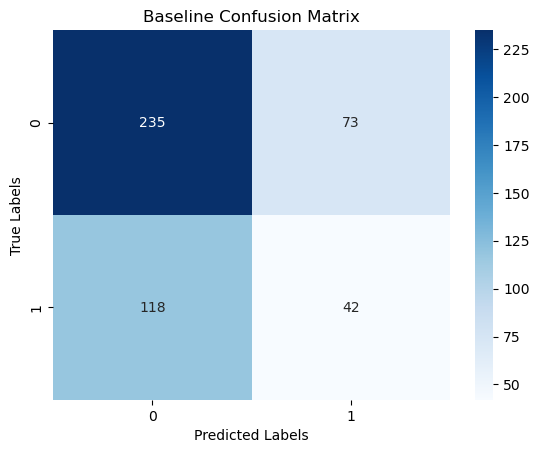

In [80]:
# Baseline method for clustering raw time series data using KMeans

# Extract raw time series data for each subject and trial
raw_features = []
raw_labels = []

for subject_id, group in eeg_data.groupby(["name", "trial number"]):
  label = 0 if "a" in group["matching condition"].iloc[0] else 1 # 0 for alcoholic, 1 for control subjects
  raw_labels.append(label)
  
  signal = group["sensor value"].values
  raw_features.append(signal)

# Convert to numpy array and pad sequences to the same length
max_length = max(len(f) for f in raw_features)
raw_features_padded = np.array([np.pad(f, (0, max_length - len(f)), 'constant') for f in raw_features])

# Standardize the features
scaler = StandardScaler()
raw_features_scaled = scaler.fit_transform(raw_features_padded)

# Perform clustering using KMeans
kmeans_baseline = KMeans(n_clusters=2, random_state=42)
predicted_labels_baseline = kmeans_baseline.fit_predict(raw_features_scaled)

# Evaluate the baseline clustering
print("Baseline Clustering Evaluation:")
print(classification_report(raw_labels, predicted_labels_baseline))
cm_baseline = confusion_matrix(raw_labels, predicted_labels_baseline)
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues')
plt.title("Baseline Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

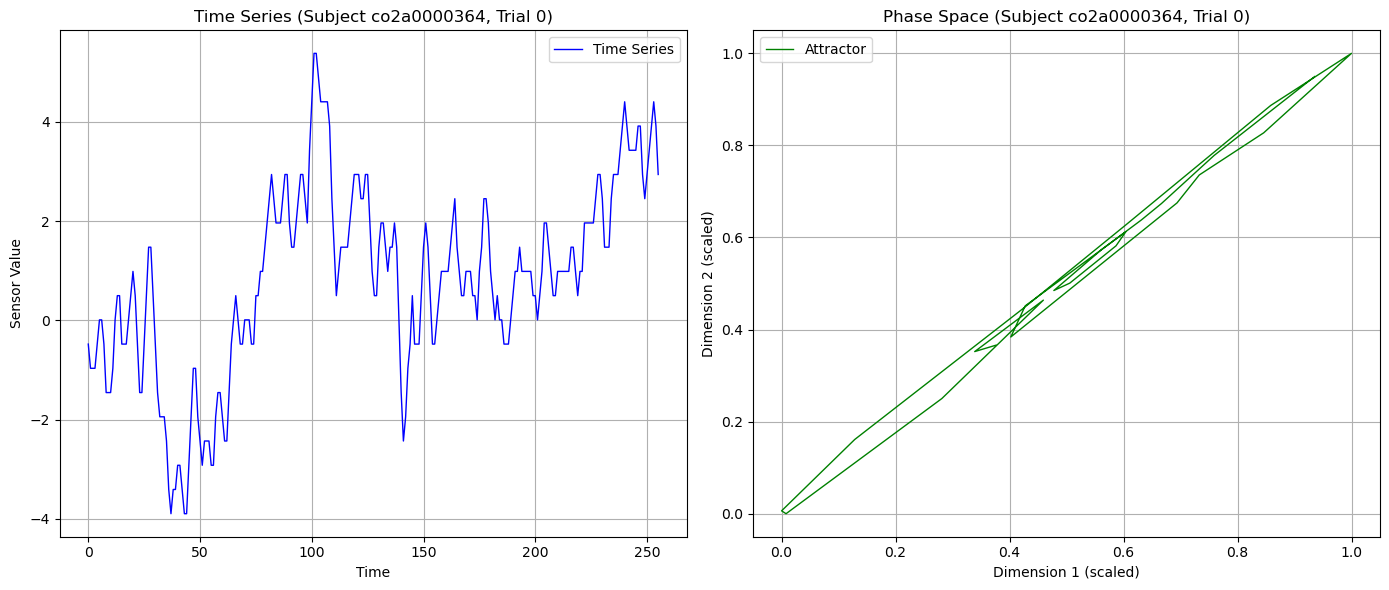

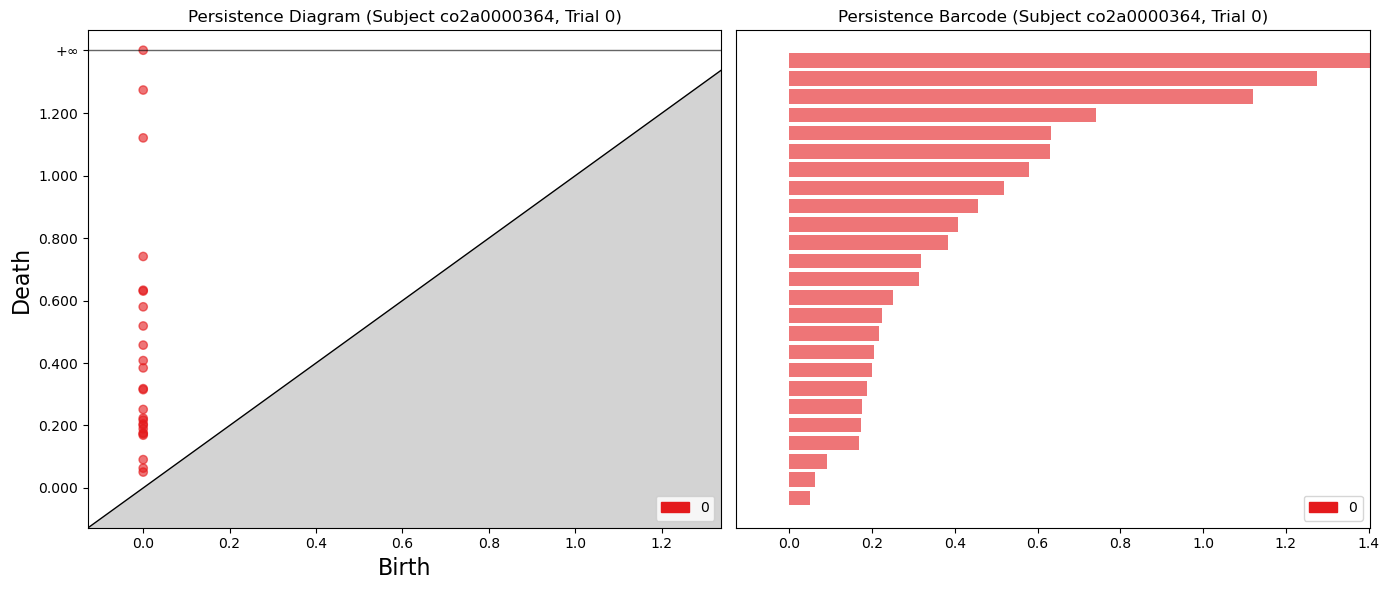

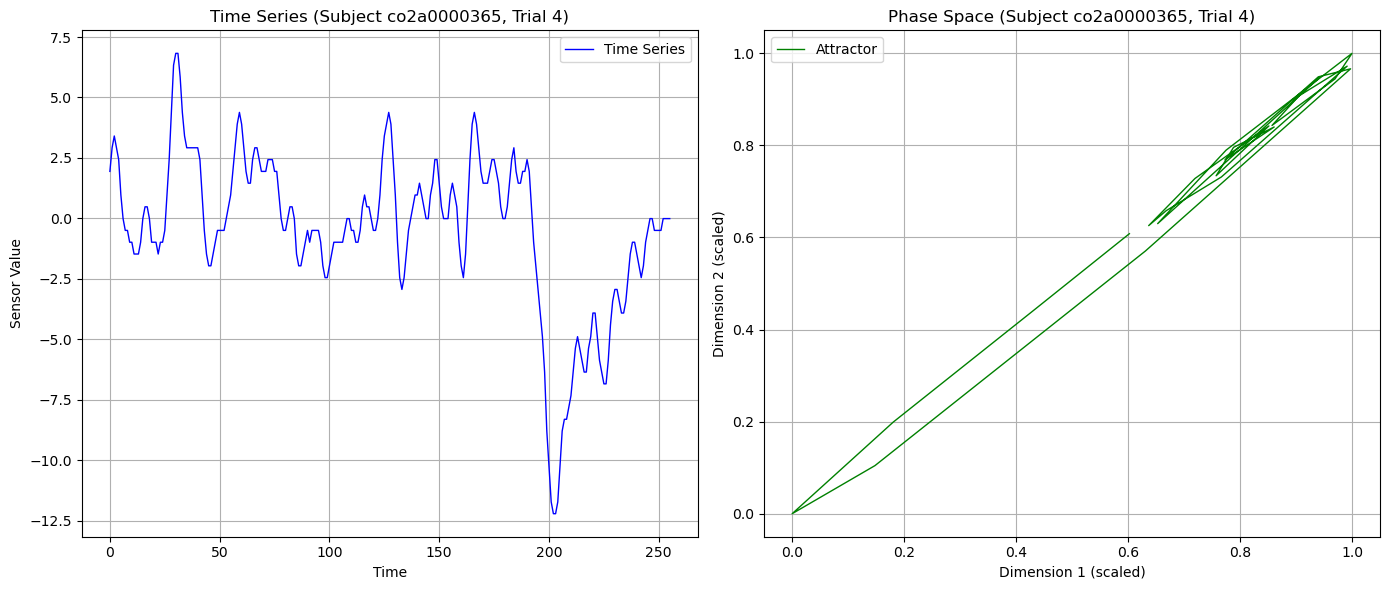

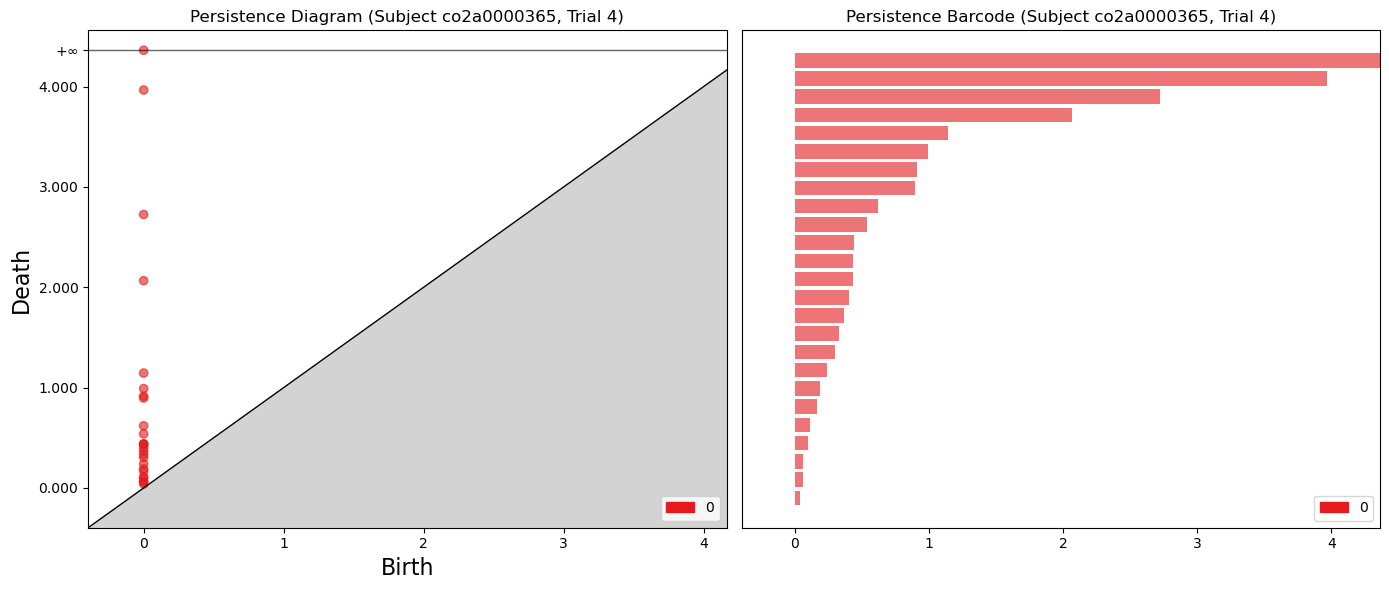

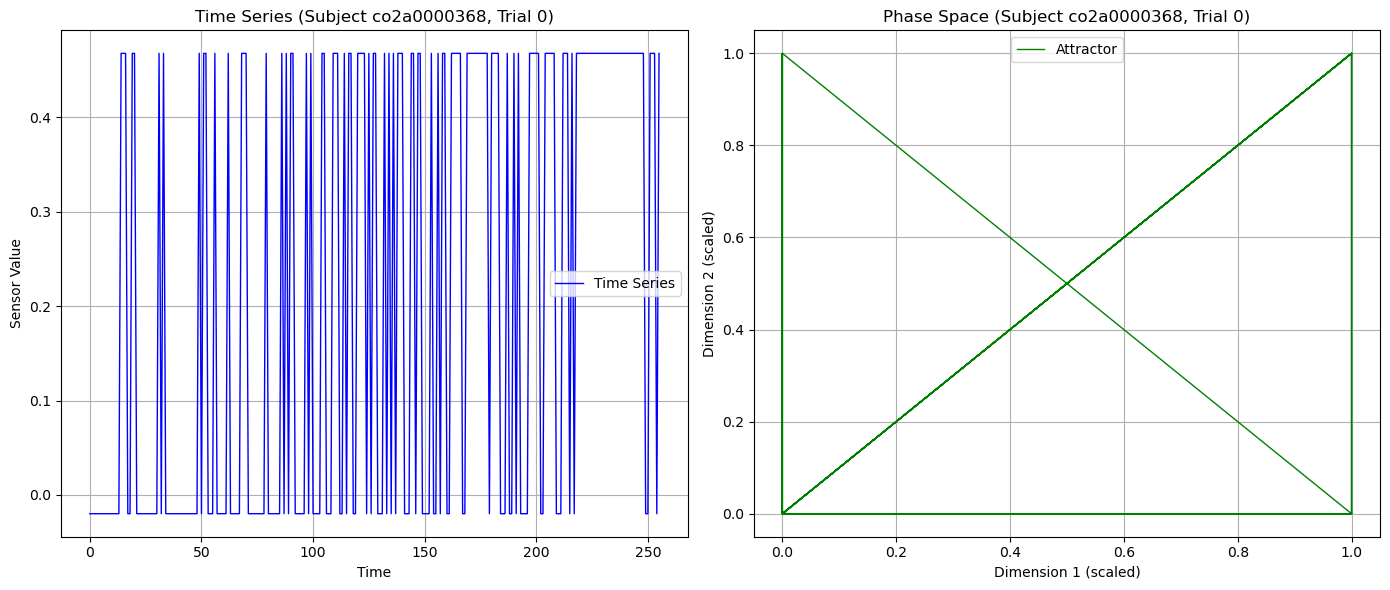

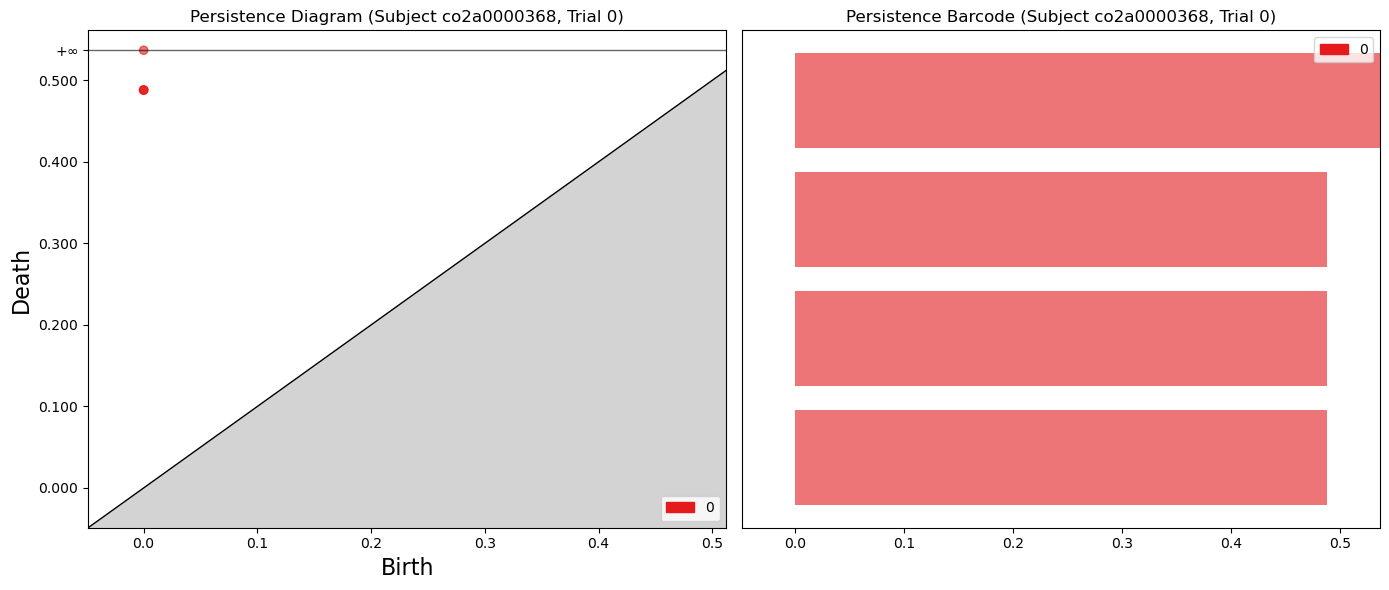

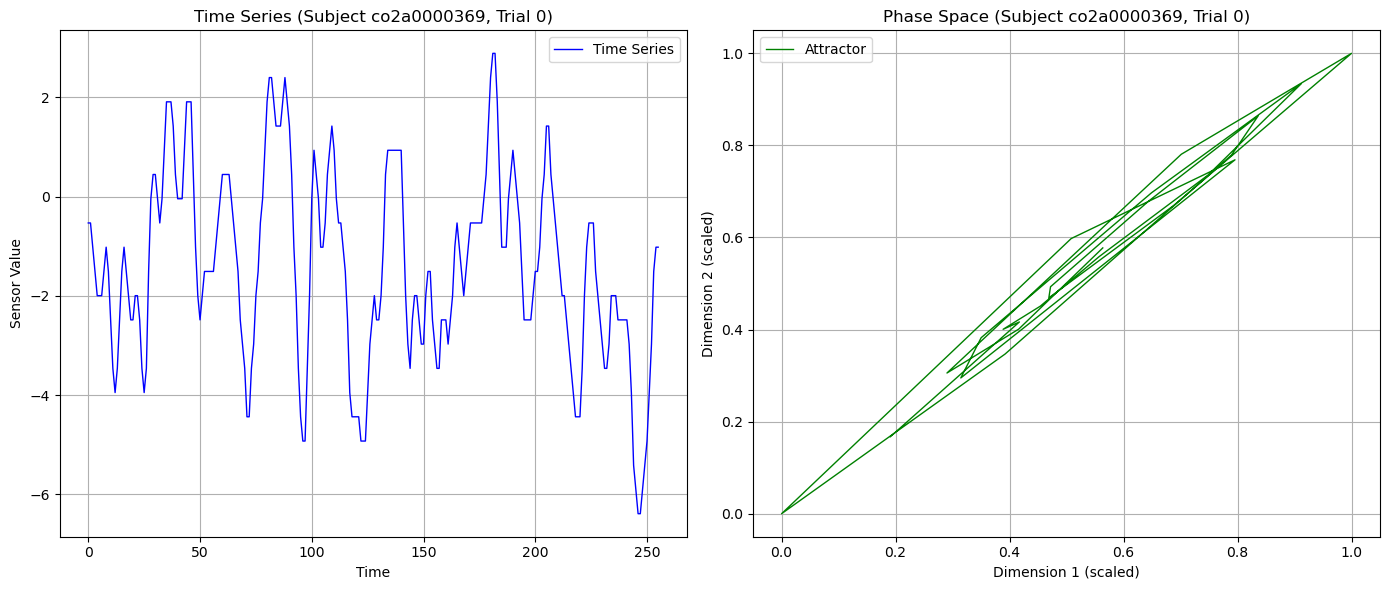

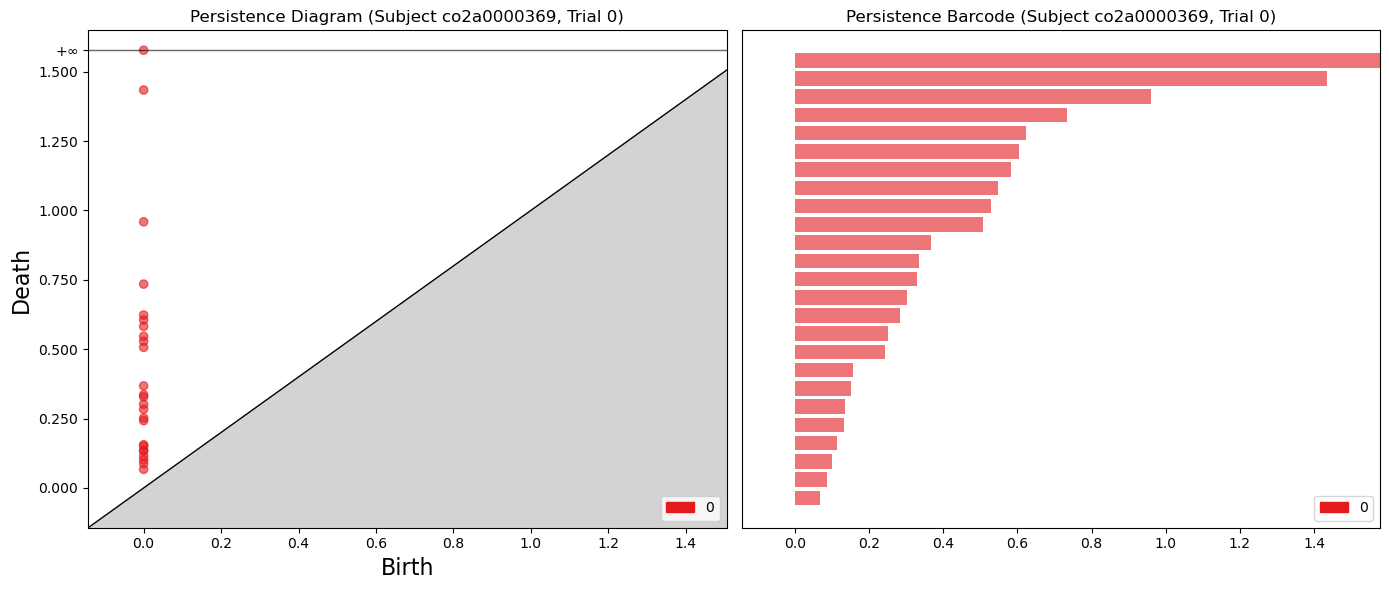

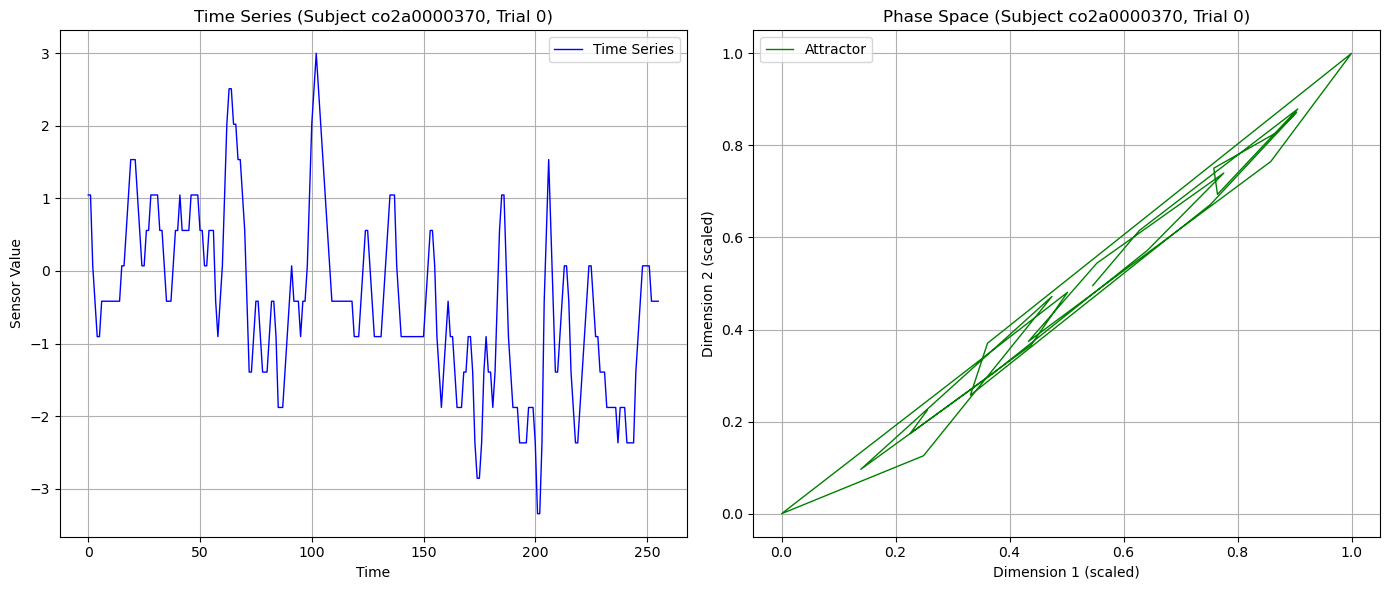

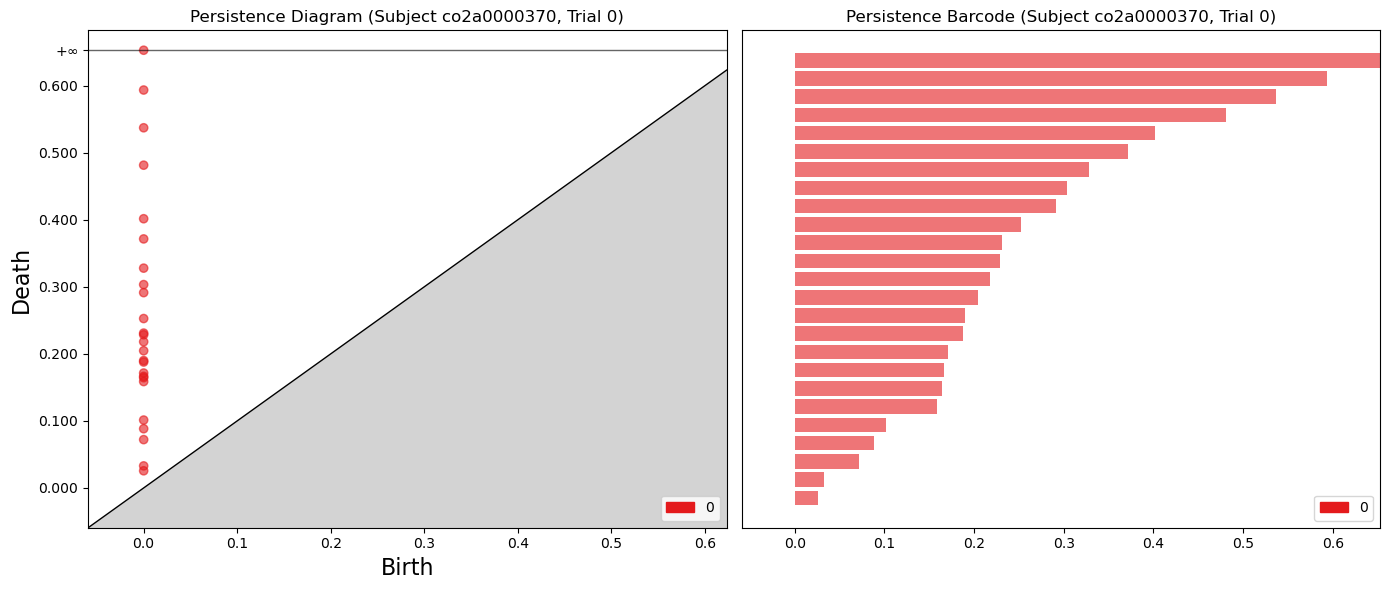

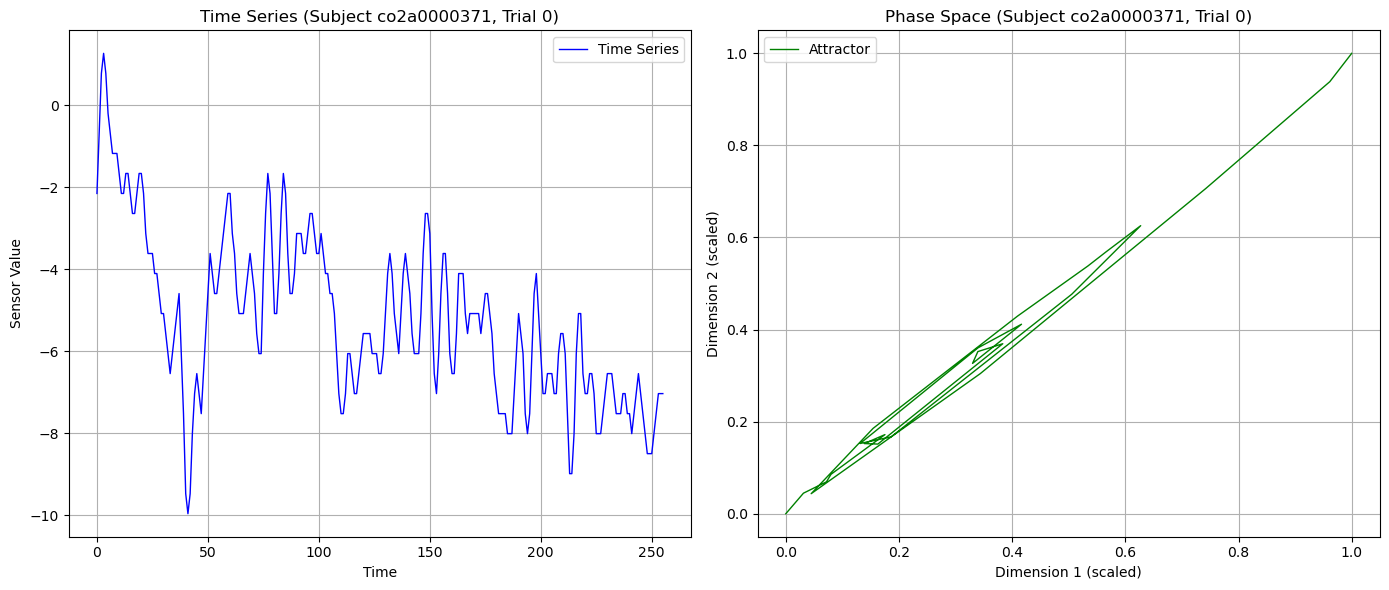

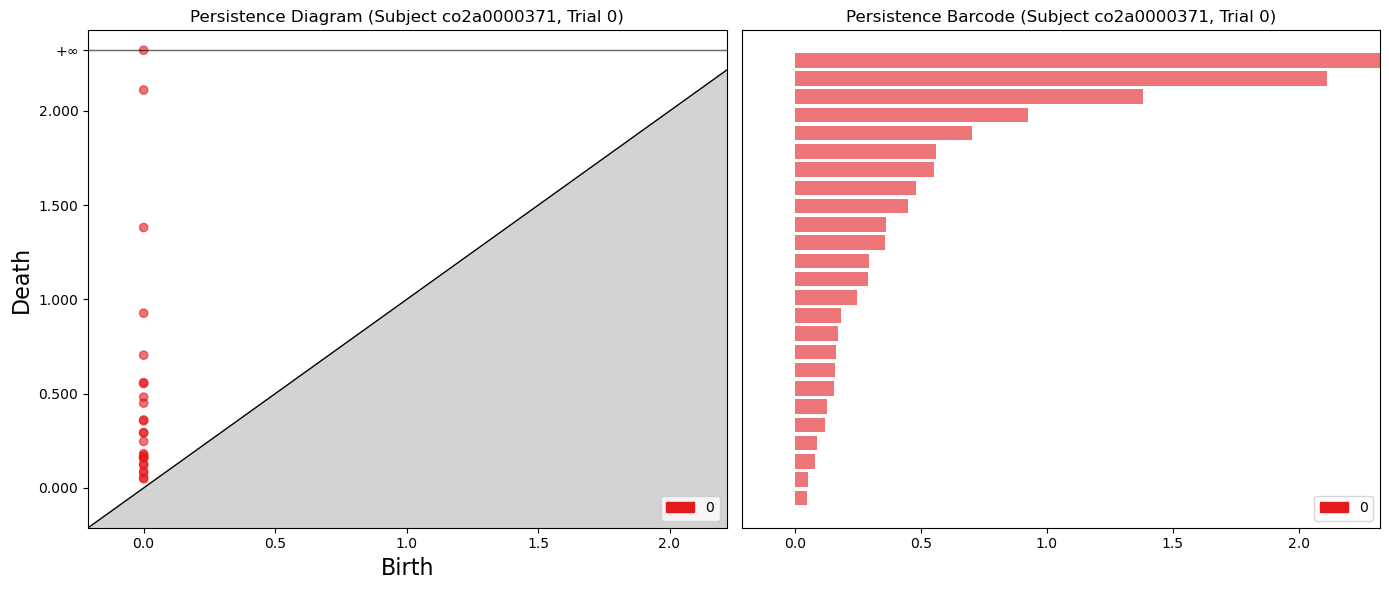

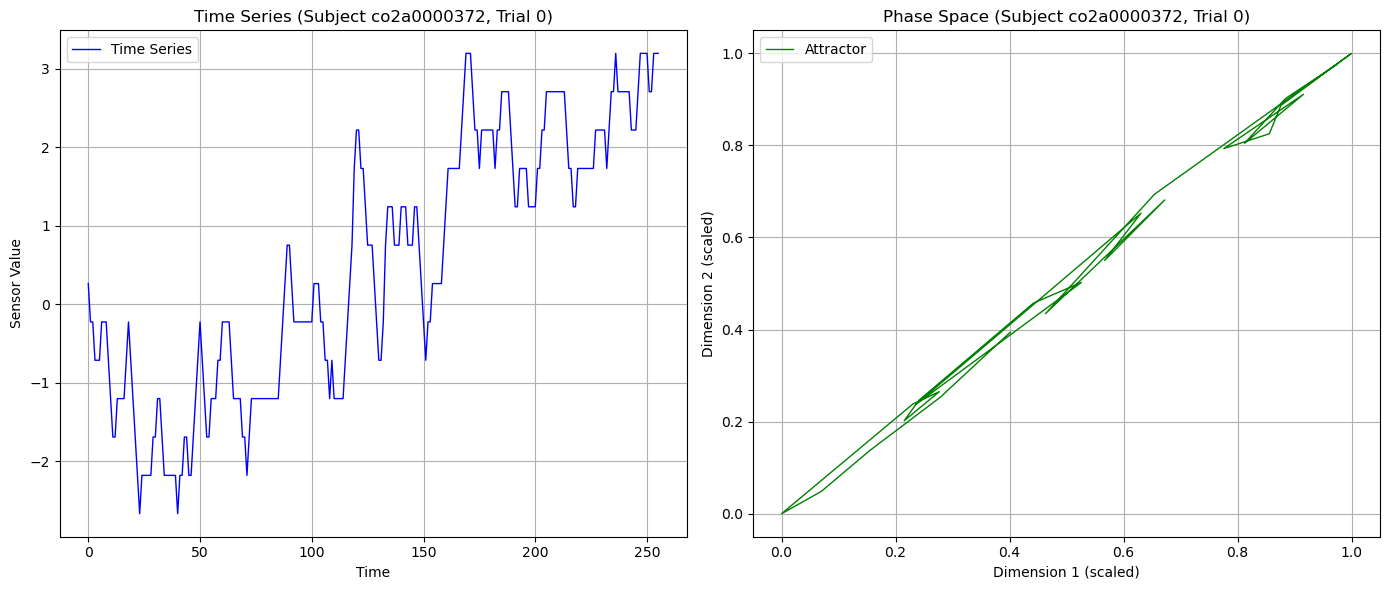

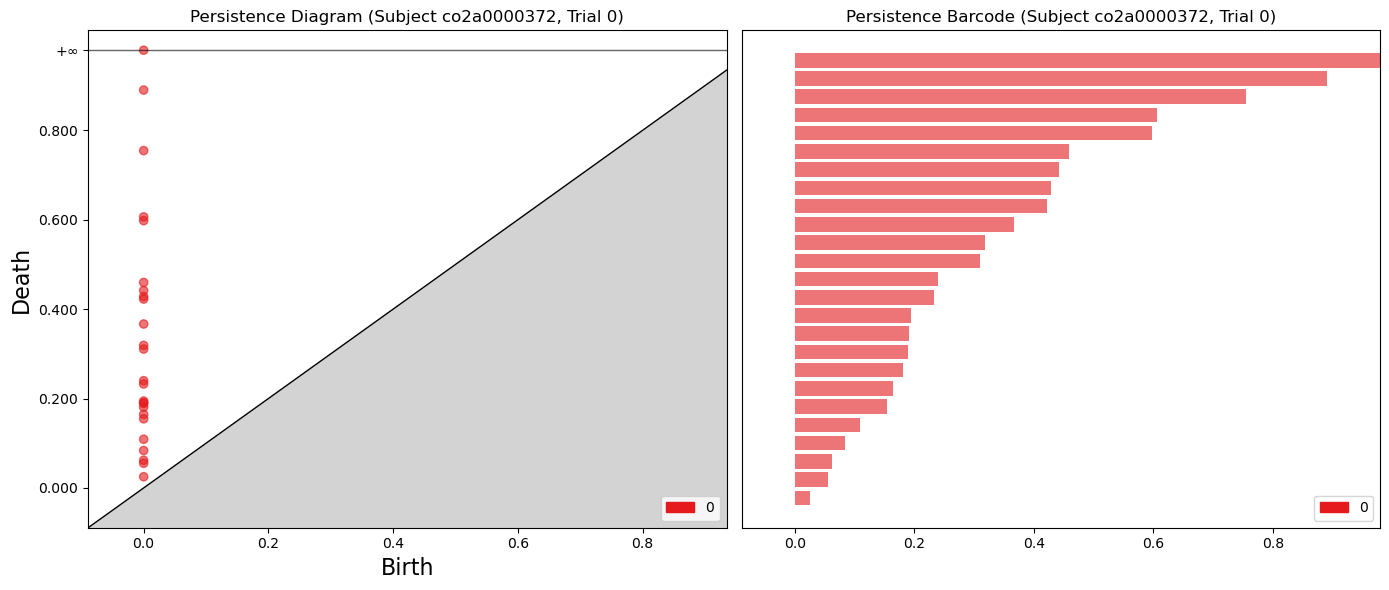

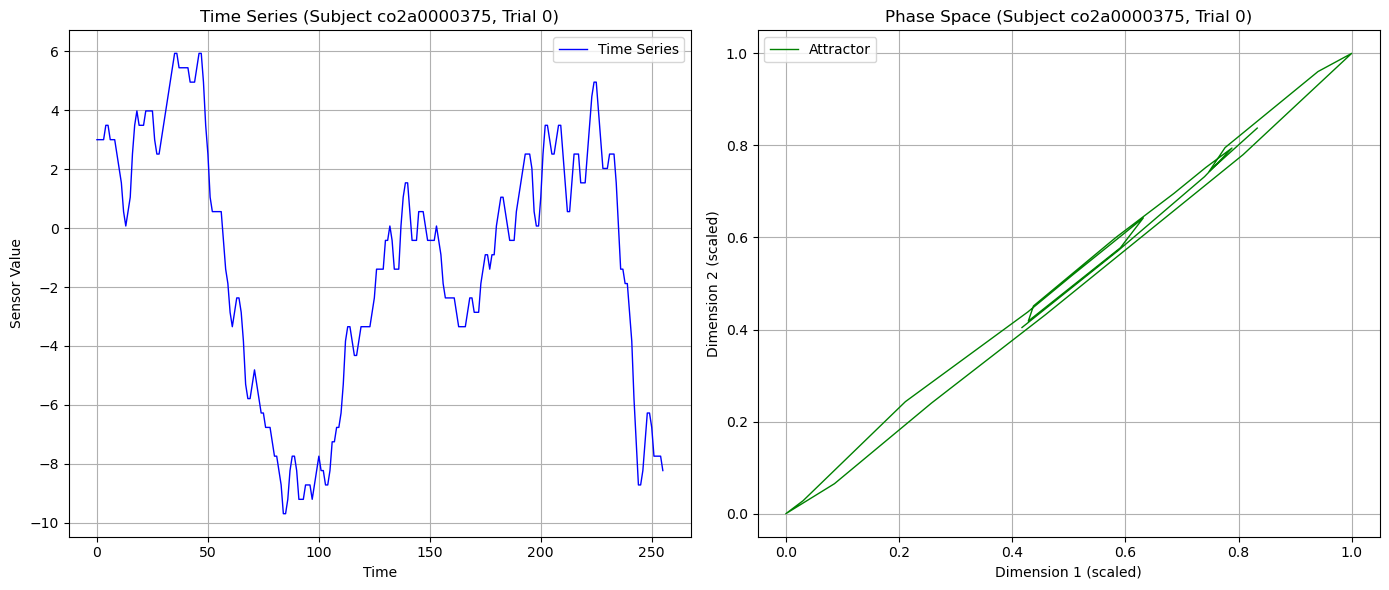

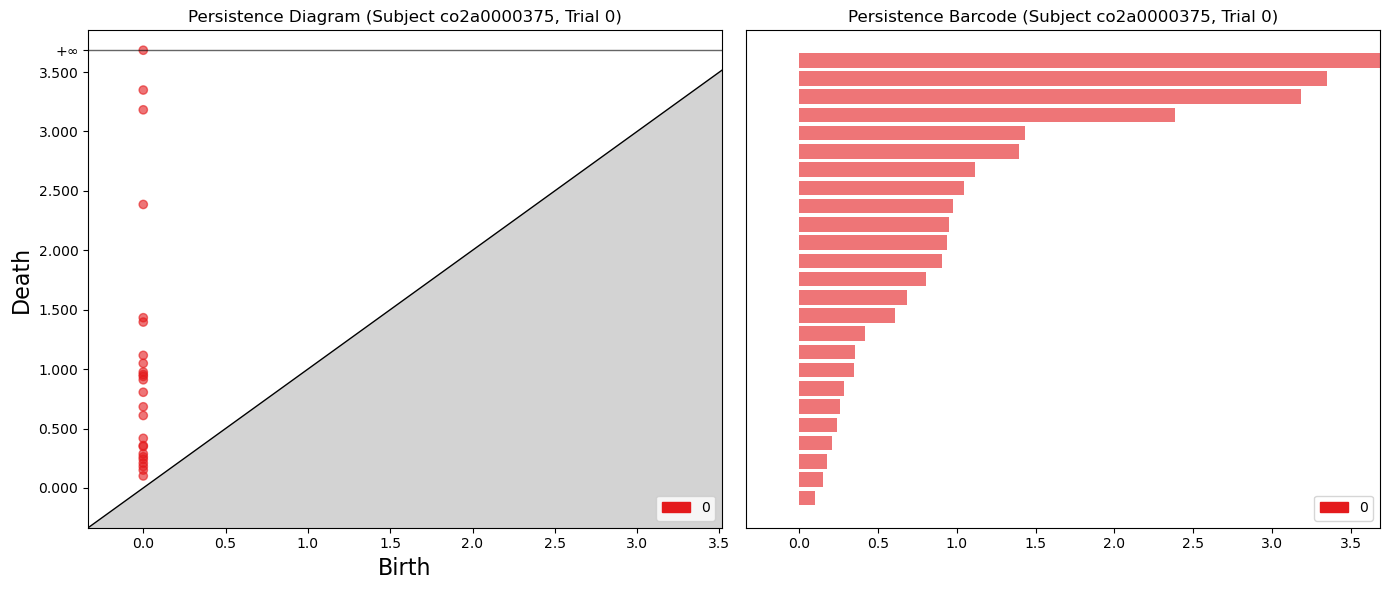

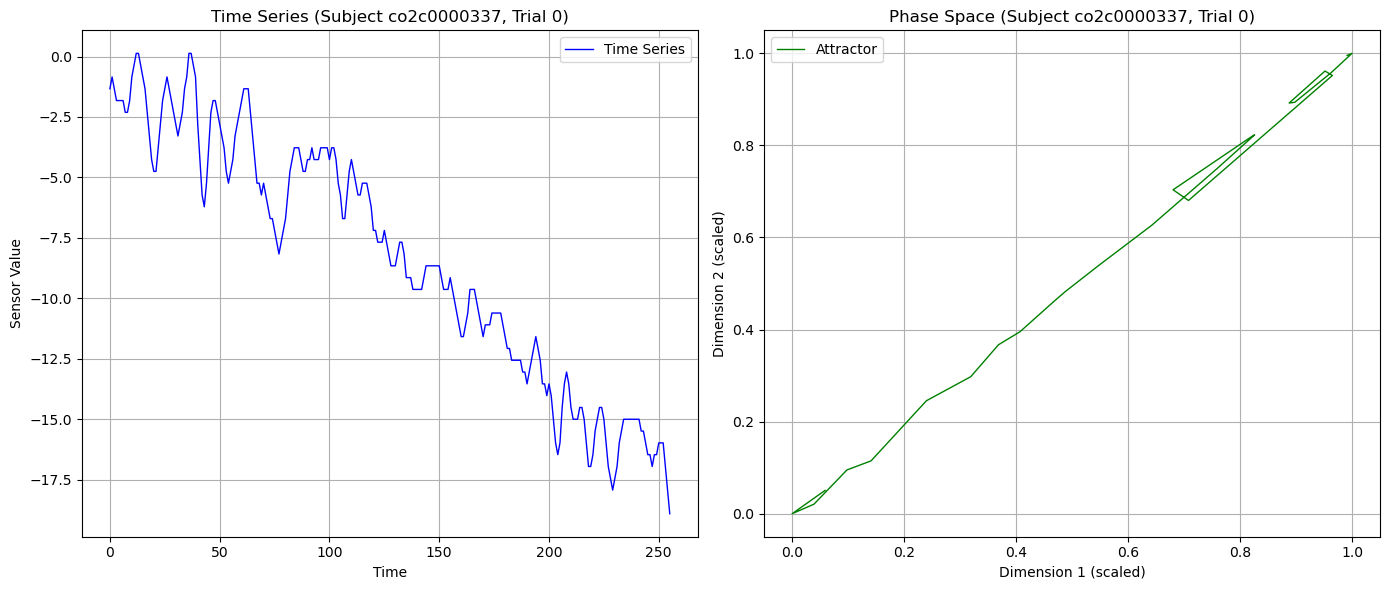

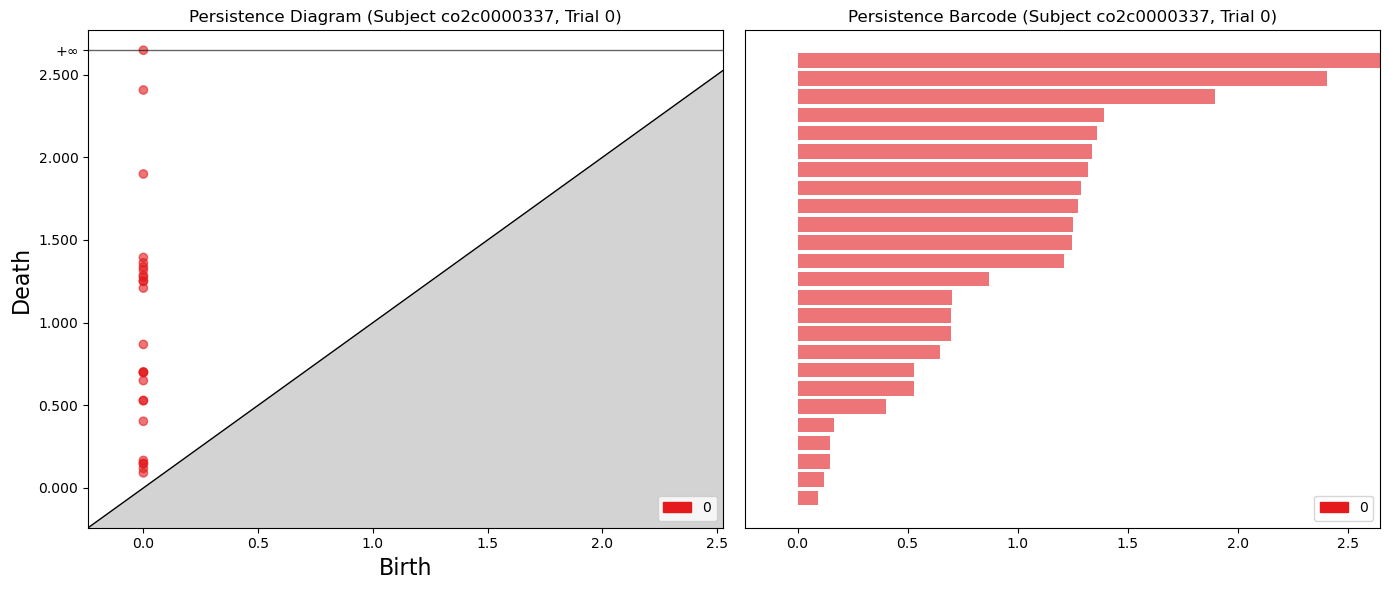

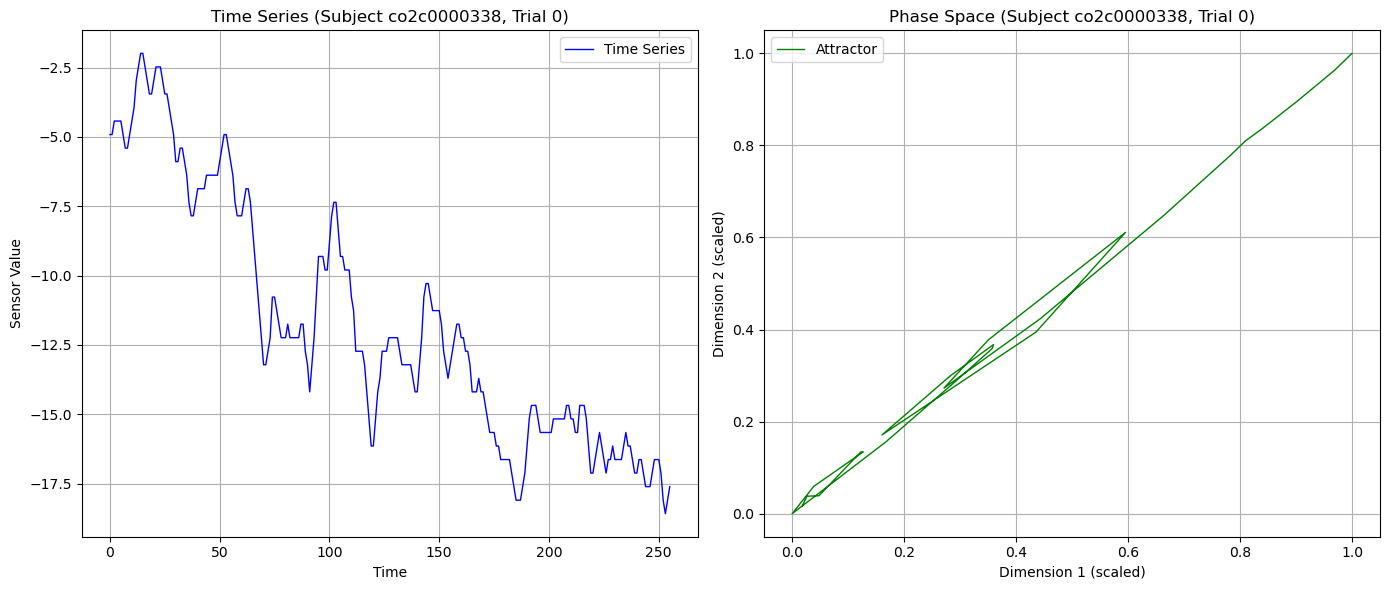

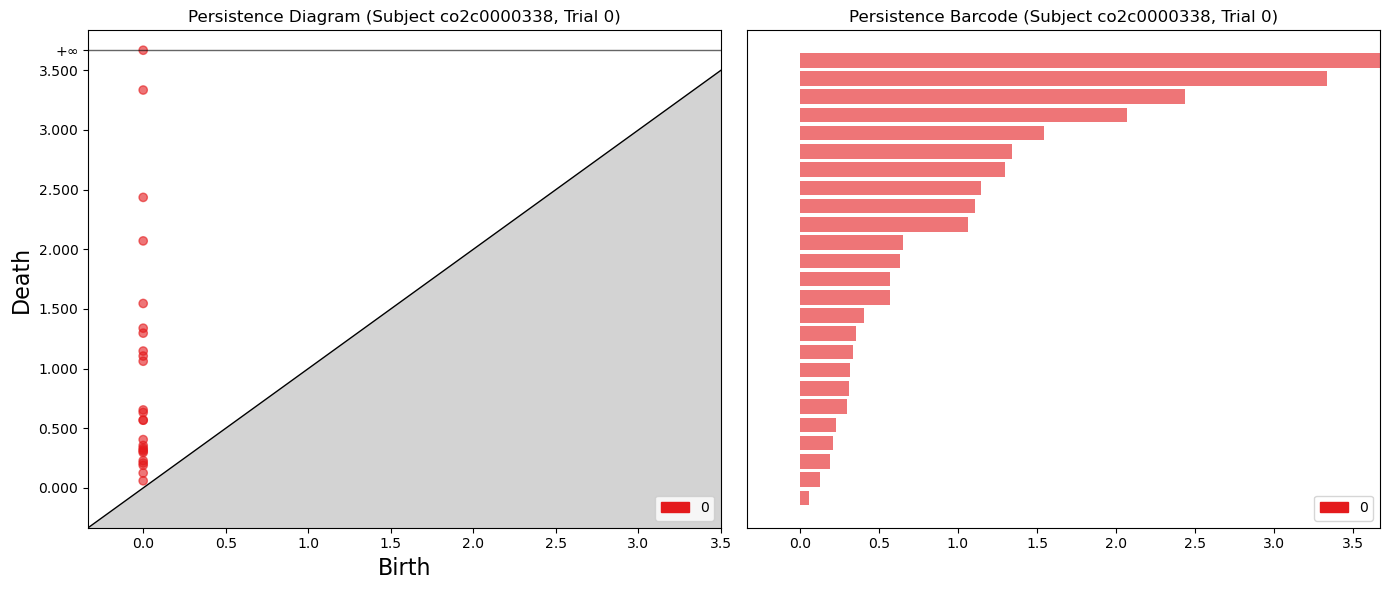

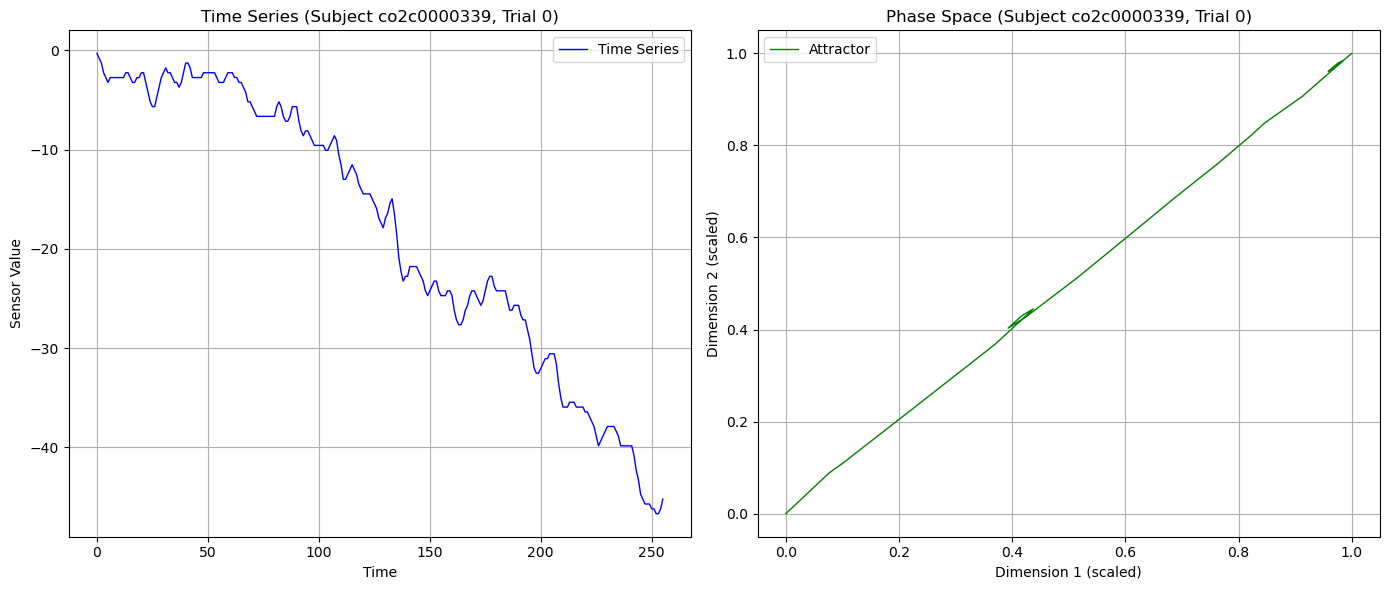

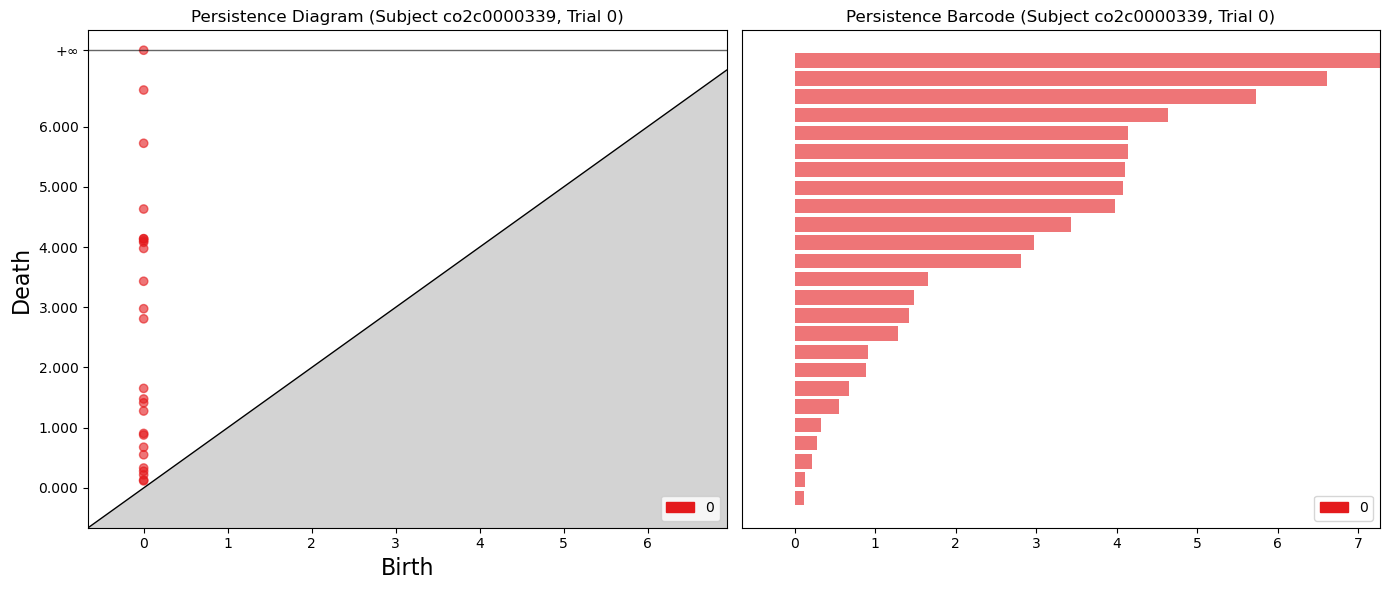

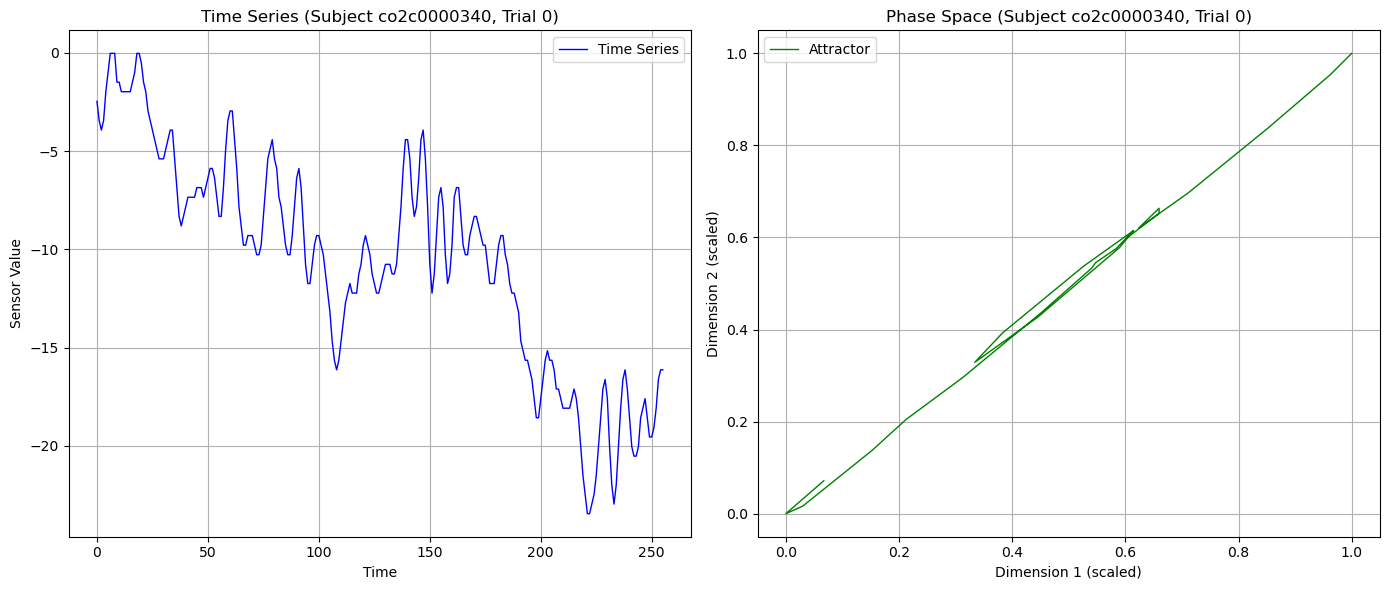

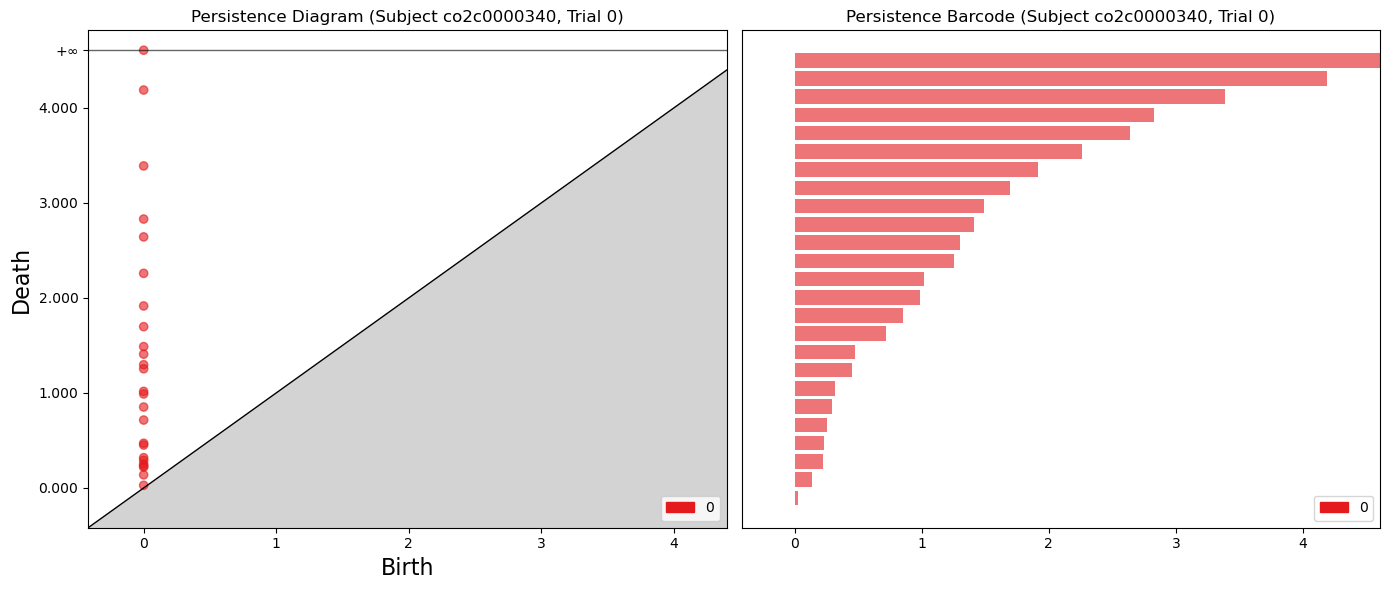

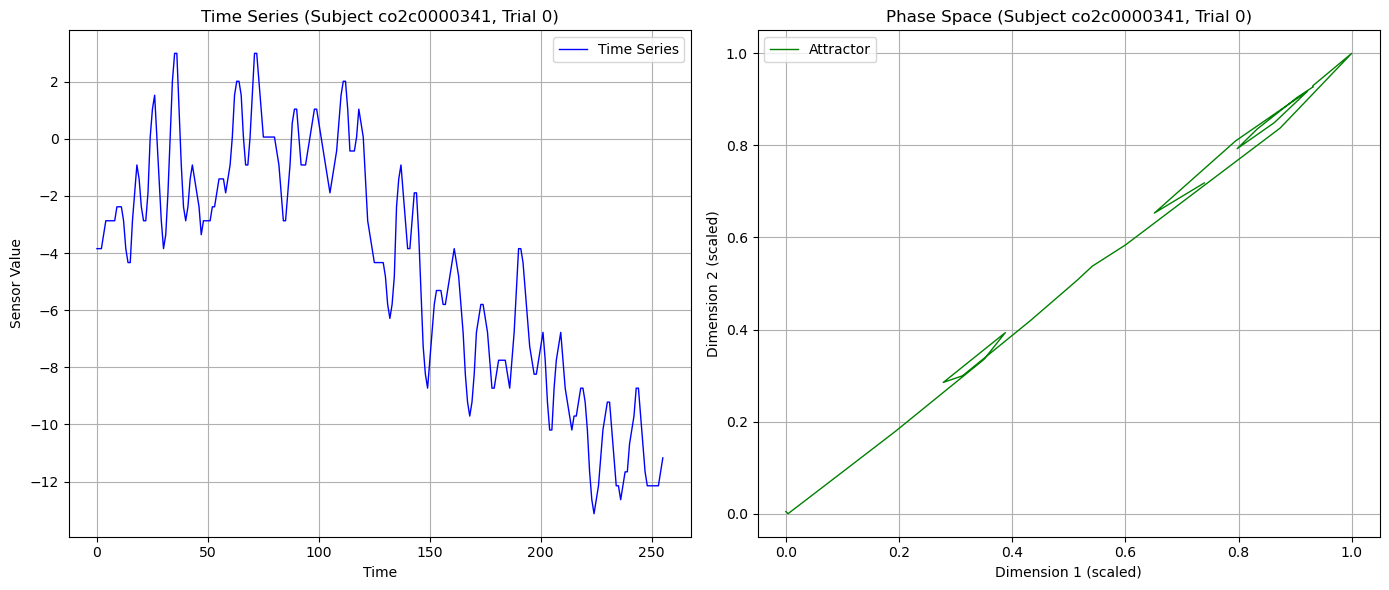

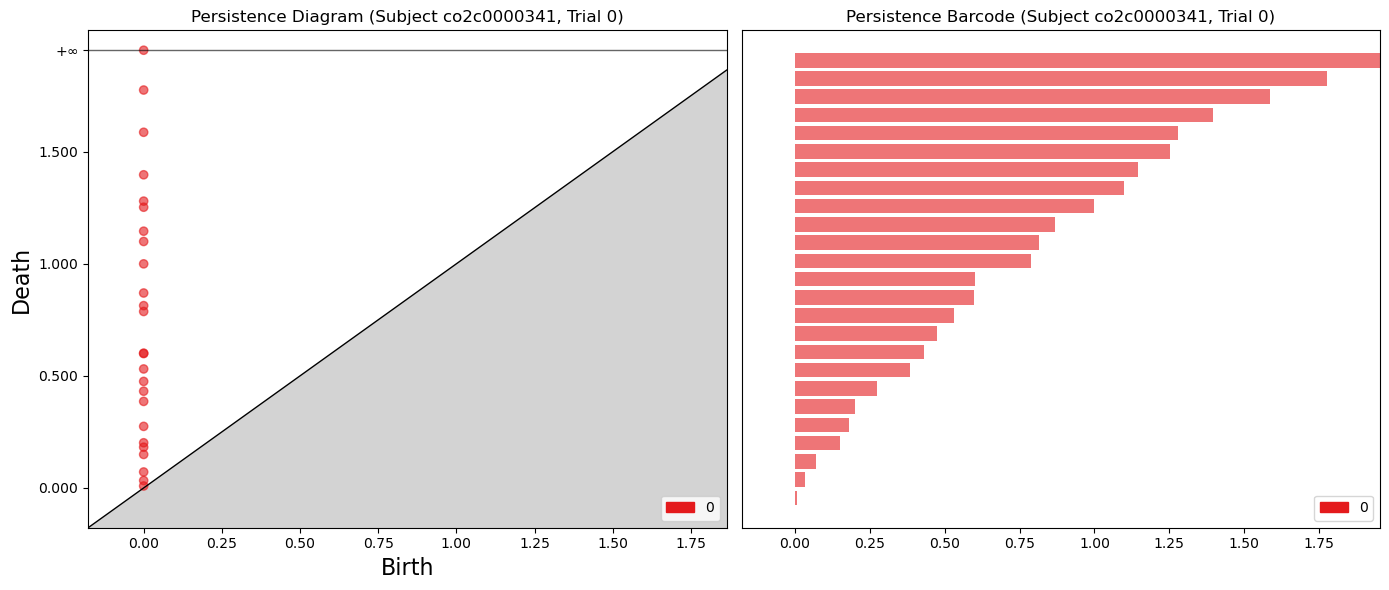

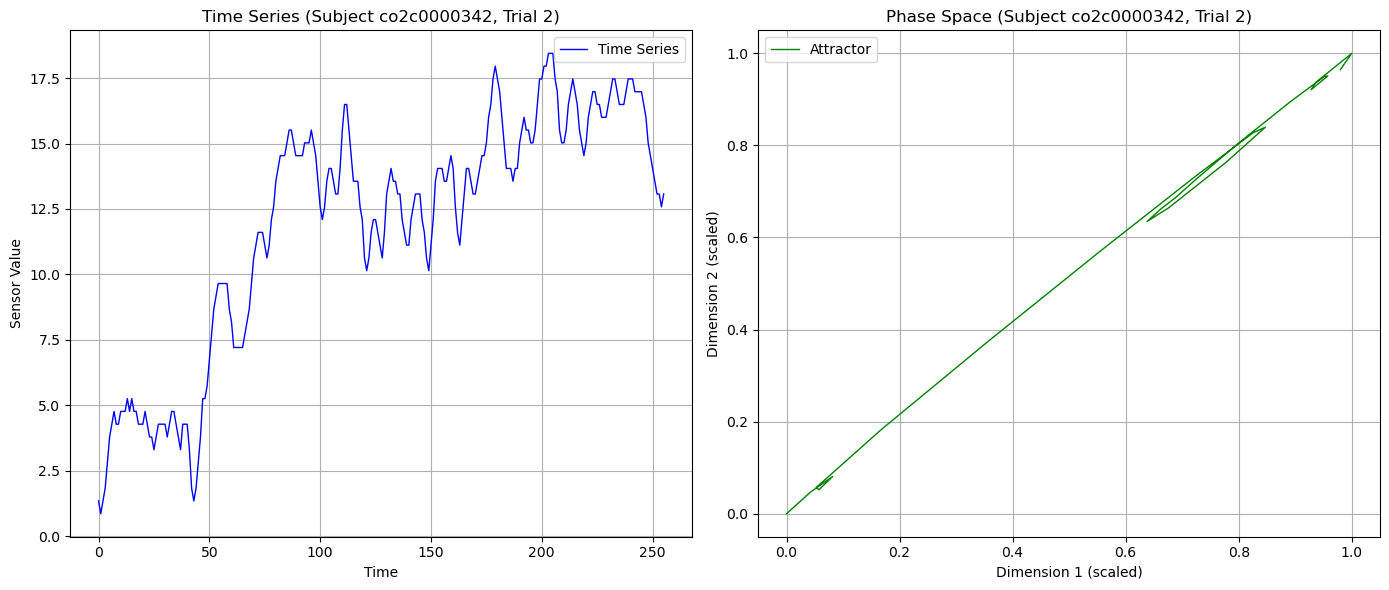

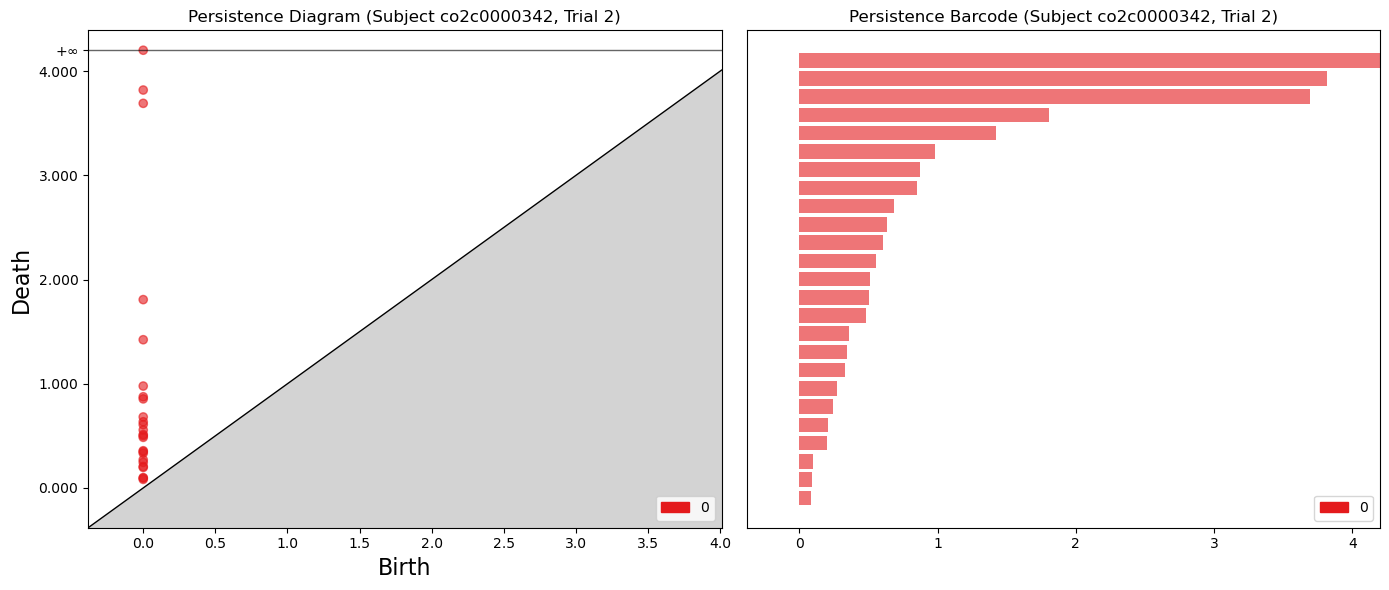

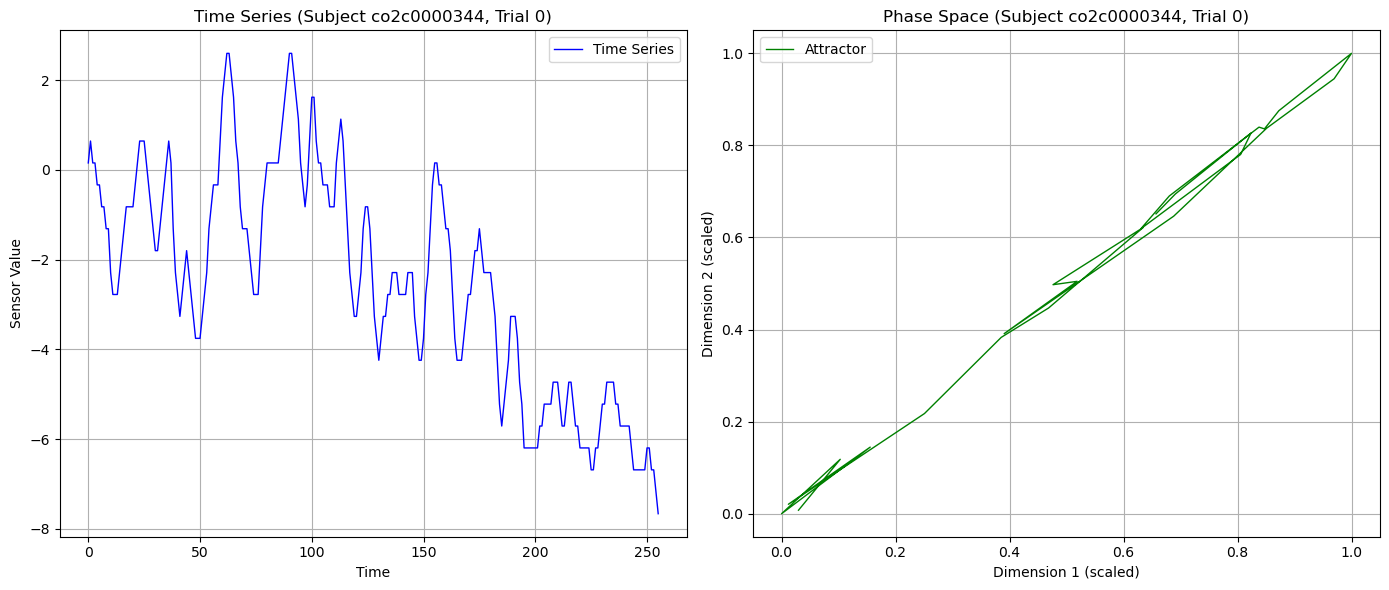

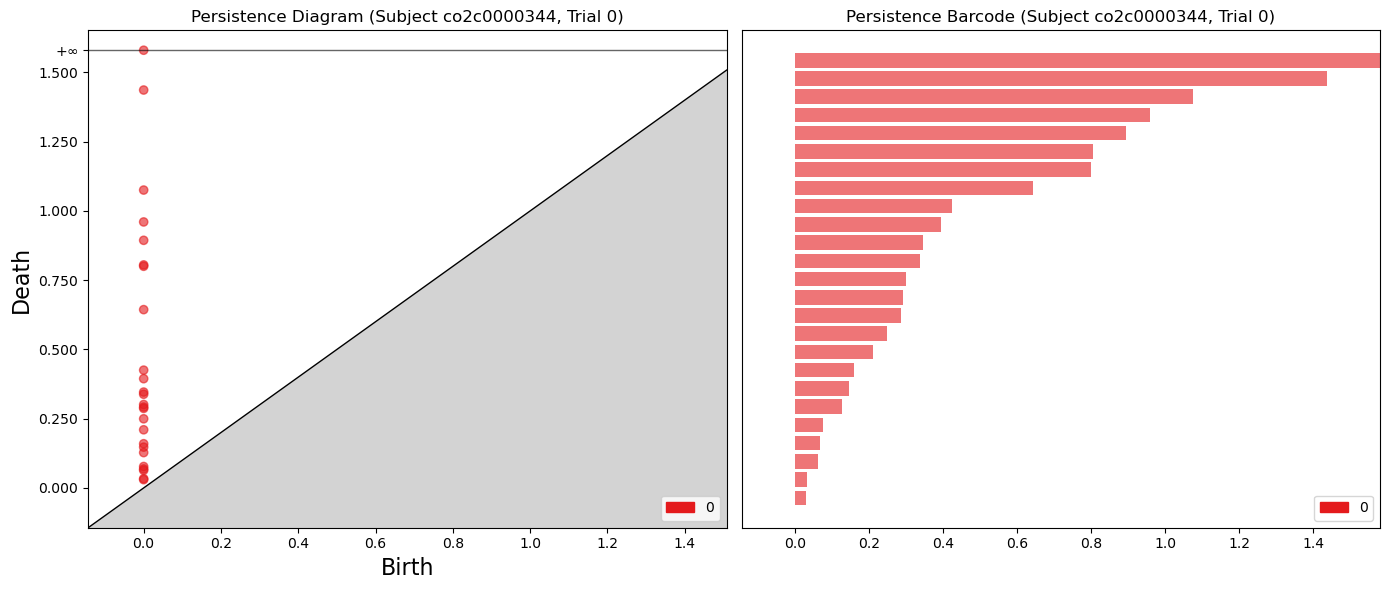

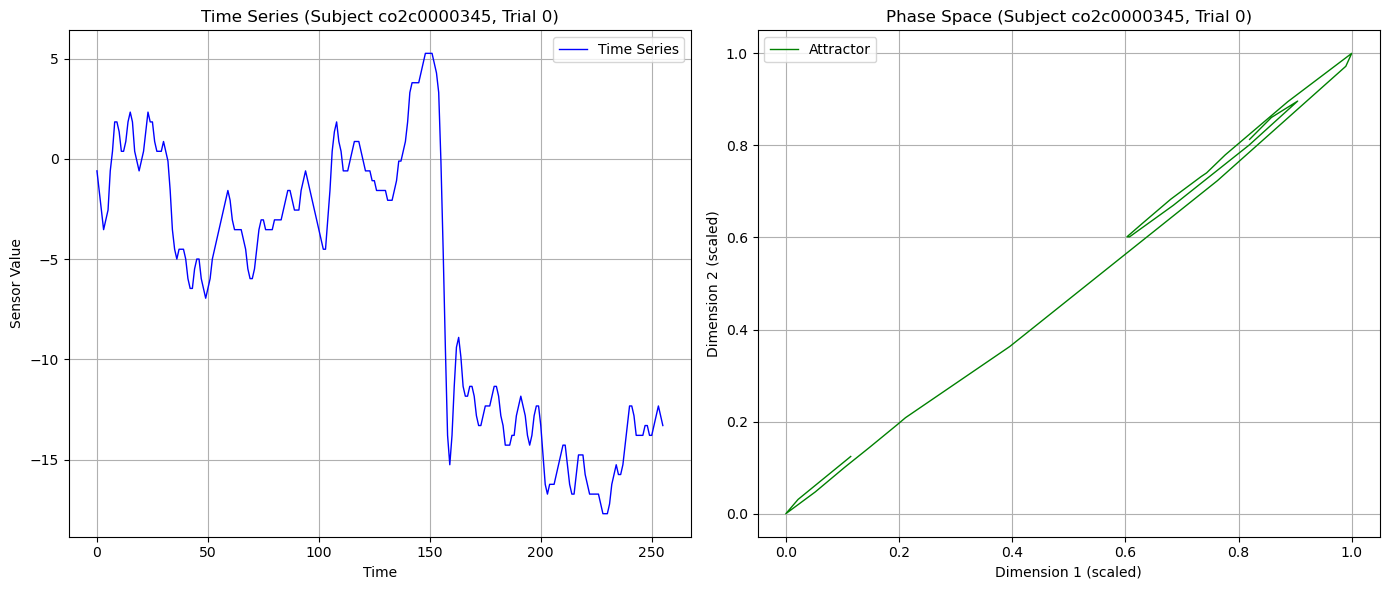

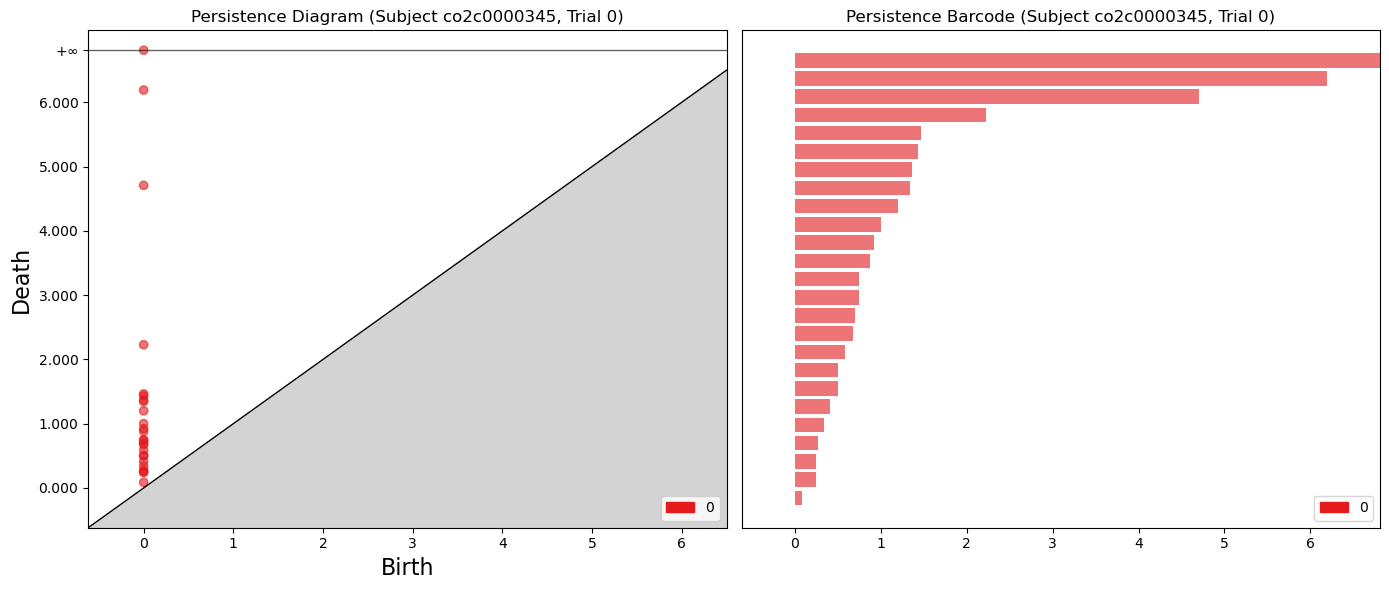

              precision    recall  f1-score   support

           0       0.67      0.75      0.71       308
           1       0.37      0.28      0.31       160

    accuracy                           0.59       468
   macro avg       0.52      0.51      0.51       468
weighted avg       0.56      0.59      0.57       468



C:\Users\marti\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


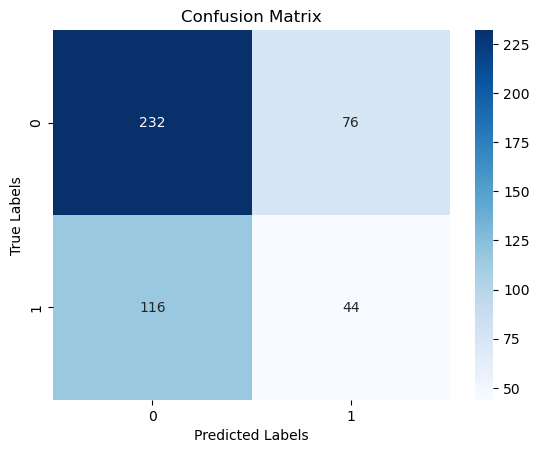

array([0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,

In [81]:
features = []
labels = []

def plot_time_series_and_attractor(signal, embedded_data, subject_id):
    """Plot the original time series and its Takens embedding attractor."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot time series
    axes[0].plot(signal, label="Time Series", color="blue", linewidth=1)
    axes[0].set_title(f"Time Series (Subject {subject_id[0]}, Trial {subject_id[1]})")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Sensor Value")
    axes[0].legend()
    axes[0].grid(True)

    # Adjust attractor data scaling for better visibility
    embedded_data_normalized = (embedded_data - np.min(embedded_data, axis=0)) / (
        np.max(embedded_data, axis=0) - np.min(embedded_data, axis=0)
    )

    # Plot attractor in 2D
    if embedded_data.shape[1] == 2:
        axes[1].plot(
            embedded_data_normalized[:, 0],
            embedded_data_normalized[:, 1],
            label="Attractor",
            color="green",
            linewidth=1,
        )
        axes[1].set_xlabel("Dimension 1 (scaled)")
        axes[1].set_ylabel("Dimension 2 (scaled)")

    axes[1].set_title(f"Phase Space (Subject {subject_id[0]}, Trial {subject_id[1]})")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

def plot_persistence_diagram_and_barcode(diagram):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot persistence diagram
    gd.plot_persistence_diagram(diagram, axes=axes[0])
    axes[0].set_title(f"Persistence Diagram (Subject {subject_id[0]}, Trial {subject_id[1]})")

    # Plot persistence barcode
    gd.plot_persistence_barcode(diagram, axes=axes[1])
    axes[1].set_title(f"Persistence Barcode (Subject {subject_id[0]}, Trial {subject_id[1]})")

    plt.tight_layout()
    plt.show()

current_id = ""
for subject_id, group in eeg_data.groupby(["name", "trial number"]):
    label = 0 if "a" in group["matching condition"].iloc[0] else 1  # Adjust based on your dataset
    labels.append(label)

    signal = group["sensor value"].values
    filtered_signal = apply_emd(signal)

    embedded_data = takens_embedding(filtered_signal, m=2, tau=10)

    if current_id != subject_id[0]: 
        plot_time_series_and_attractor(signal, embedded_data, subject_id)

    persistence_diagram = compute_persistence_diagram(embedded_data)
    
    if current_id != subject_id[0]: 
        plot_persistence_diagram_and_barcode(persistence_diagram)
    
    current_id = subject_id[0]

    subject_features = extract_features(persistence_diagram)
    features.append(subject_features)

# Cluster and evaluate
features = np.array(features)
labels = np.array(labels)
cluster_and_evaluate(features, labels)

In [82]:
# import numpy as np
# import pandas as pd
# from pyemd import emd
# from sklearn.cluster import KMeans
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from ripser import ripser
# from persim import plot_diagrams
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt

# # Load the preprocessed EEG data
# data = pd.read_csv("your_dataset.csv")

# # Step 1: Preprocess the data
# def preprocess_data(df, sensor="CPZ"):
#     """Filter data for a specific sensor and apply noise reduction if necessary."""
#     sensor_data = df[df['sensor position'] == sensor]
#     grouped = sensor_data.groupby('trial number')
#     trials = [group[1]['sensor value'].values for group in grouped]
#     return trials

# trials = preprocess_data(data)

# # Step 2: Reconstruct phase space
# def takens_embedding(series, embedding_dim=2, delay=10):
#     """Reconstruct attractor using Takens' theorem."""
#     n_points = len(series) - (embedding_dim - 1) * delay
#     embedded = np.array([series[i:i + n_points] for i in range(0, embedding_dim * delay, delay)]).T
#     return embedded

# embedded_trials = [takens_embedding(trial) for trial in trials]

# # Step 3: Compute persistent homology
# def compute_persistence(data):
#     """Compute persistent homology and return persistence diagrams."""
#     diagrams = ripser(data)['dgms']
#     return diagrams

# persistence_diagrams = [compute_persistence(trial) for trial in embedded_trials]

# # Step 4: Extract features from persistence diagrams
# def extract_features(diagrams):
#     """Extract features like the number of holes, maximum lifetime, and average lifetime."""
#     features = []
#     for dim, diag in enumerate(diagrams):
#         if len(diag) > 0:
#             lifetimes = diag[:, 1] - diag[:, 0]
#             max_lifetime = np.max(lifetimes)
#             avg_lifetime = np.mean(lifetimes)
#             features.append([len(diag), max_lifetime, avg_lifetime])
#         else:
#             features.append([0, 0, 0])
#     return np.array(features).flatten()

# all_features = np.array([extract_features(diagrams) for diagrams in persistence_diagrams])

# # Standardize the features
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(all_features)

# # Step 5: Cluster the data
# kmeans = KMeans(n_clusters=2, random_state=42)
# kmeans.fit(scaled_features)
# labels = kmeans.labels_

# # Step 6: Evaluate the results
# # Assuming ground truth is available in the dataset
# # Replace 'ground_truth_column' with the actual column name containing labels
# ground_truth = data.drop_duplicates('trial number')['matching condition'].map(lambda x: 1 if 'alcoholic' in x else 0).values

# accuracy = accuracy_score(ground_truth, labels)
# precision = precision_score(ground_truth, labels)
# recall = recall_score(ground_truth, labels)
# f1 = f1_score(ground_truth, labels)

# print(f"Accuracy: {accuracy:.2f}")
# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")
# print(f"F1 Score: {f1:.2f}")

# # Step 7: Visualize sample persistence diagrams
# sample_index = 0
# plot_diagrams(persistence_diagrams[sample_index], title="Persistence Diagram for Sample Trial")
# plt.show()


In [83]:
# import gudhi as gd
# import numpy as np
# import matplotlib.pyplot as plt

# test = [1,4,6,8,9,10,12]

# n = [0,1,2,3,4,5,6]

# angles = [r/6*np.pi for r in test]
# x, y = np.sin(angles), np.cos(angles)
# points = [[x[i],y[i]] for i in n]

# fig, ax = plt.subplots()
# ax.scatter(x, y)
# plt.gca().set_aspect('equal', adjustable='box')
# for i, txt in enumerate(test):
#   ax.annotate(txt, (x[i]-0.05, y[i]+0.05))
# plt.show()

# rips_complex = gd.RipsComplex(points=points,max_edge_length=10)
# simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)
# print(tuple(simplex_tree.get_filtration()))

# for t in [0.75, 1, 1.5, 1.75, 1.95, 2.5]:
#   rips_complex = gd.RipsComplex(points=points,max_edge_length=t)
#   simplex_tree = rips_complex.create_simplex_tree(max_dimension=4)
#   filtration_simplex_tree = tuple(simplex_tree.get_filtration())
#   print("--")
#   print("threshold: ",t)
#   print("vertices: ",[p for p in tuple(simplex_tree.get_simplices()) if len(p[0])==1])
#   print("edges: ",[p for p in tuple(simplex_tree.get_simplices()) if len(p[0])==2])
#   print("triangles: ",[p for p in tuple(simplex_tree.get_simplices()) if len(p[0])==3])
#   print("3-simplex: ",[p for p in tuple(simplex_tree.get_simplices()) if len(p[0])==4])
#   edges = np.array([p[0] for p in tuple(simplex_tree.get_simplices()) if len(p[0])==2])
#   triangles = np.array([p[0] for p in tuple(simplex_tree.get_simplices()) if (p[1] < t and len(p[0])==3)])
#   fig, ax = plt.subplots()
#   ax.scatter([p[0] for p in points],[p[1] for p in points],color='k')
#   ax.plot(x[edges.T], y[edges.T], linestyle='-',color='k')
#   for triangle in triangles:
#         ax.fill(x[triangle], y[triangle], color='lightblue', alpha=0.3)
#   plt.gca().set_aspect('equal', adjustable='box')
#   for i, txt in enumerate(test):
#     ax.annotate(txt, (x[i]-0.05, y[i]+0.05))
#   plt.show()

# # We compute the Barcode
# gd.plot_persistence_barcode(simplex_tree.persistence())
# plt.show()

# # We compute the Diagram
# gd.plot_persistence_diagram(simplex_tree.persistence())
# plt.show()